# Automated Georeferencing

In [1]:
import sys
import numpy as np
from math import atan2, degrees, radians, cos, sin, sqrt

import cv2
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.spatial.distance import euclidean
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde
from scipy.optimize import minimize_scalar, minimize
from scipy.ndimage import affine_transform


## Step 1. Extract Fiducial Marks


In [2]:
def find_fiducial_marks(source_image_path, mark_path, output, th=0.999):
    im_source = cv2.imread(cv2.samples.findFile(source_image_path), cv2.IMREAD_COLOR)
    im_gray = cv2.cvtColor(im_source, cv2.COLOR_BGR2GRAY)
    im_mark = cv2.imread(cv2.samples.findFile(mark_path), cv2.IMREAD_COLOR)
    im_mark_gray = cv2.cvtColor(im_mark, cv2.COLOR_BGR2GRAY)

    im = im_gray.copy()
    methods = [
        'cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
        'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
    method = eval(methods[1])

    res = cv2.matchTemplate(im, im_mark_gray, method)
    threshold = np.quantile(res, th)
    res[res<threshold] = 0
    cv2.imwrite(output, 255*res)
    

def find_center(mark_path, **kargs):
    im_circle_color = cv2.imread(cv2.samples.findFile(mark_path), cv2.IMREAD_COLOR)
    im_circle = cv2.cvtColor(im_circle_color, cv2.COLOR_BGR2GRAY)
    
    circles = cv2.HoughCircles(
        im_circle,cv2.HOUGH_GRADIENT,1,30,
        param1=kargs['param1'],param2=kargs['param2'],minRadius=kargs['minRadius'],maxRadius=kargs['maxRadius'])
    print("circles.shape", circles.shape)
    return circles


In [3]:
# sbcd
sbcdf = "data/sbcd-blue.png"
markf = "data/fiducial_mark.sbcd.png"
outf = "output/B08C.sbcds.sorted.out.png"

hnef = "data/hist_90.tif"
markf_hne = "data/fiducial_mark.HnE.png"
outf_hne = "output/hist.out.png"

find_fiducial_marks(sbcdf, markf, outf)
circles_sbcd = find_center(outf, param1=200, param2=10, minRadius=2, maxRadius=15)

find_fiducial_marks(hnef, markf_hne, outf_hne, th=0.999)
circles_hist = find_center(outf_hne, param1=500, param2=10, minRadius=2, maxRadius=15)

circles.shape (1, 342, 3)
circles.shape (1, 55, 3)


## Step 2. Construct Grid Graph

We are going to construct grid graph by following process.

connect to 3-nearest vertices
identify cardinal angles by finding two peak angles of the edges
remove diagonal edges that are significantly different from cardinal angles
The grid graph will help to identify scale factor and rotation angles required to match the histology to sbcd.

In [4]:
def construct_nearest_graph(center_points):
    points = center_points[:, :,:2][0]
    tree = KDTree(points)
    num_neighbors = 4  # including itself

    edges = []
    for point in points:
        distances, indices = tree.query(point, k=num_neighbors)
        for i in indices[1:]:
            bearing, length = calculate_bearing_length(point, points[i])
            edges.append((point, points[i], bearing, length))
    return points, edges
    

def calculate_bearing_length(point1, point2):
    dx = point2[0] - point1[0]
    dy = point2[1] - point1[1]
    bearing = np.degrees(np.arctan2(dy, dx)) % 180
    length = sqrt(dx*dx + dy*dy)
    return bearing, length

def calculate_bearing_angles(edges):
    """Calculate the bearing angles of edges."""
    angles = []
    for edge in edges:
        point0 = edge[0]
        point1 = edge[1]
        dx = point0[0] - point1[0]
        dy = point0[1] - point1[1]
        bearing = atan2(dy, dx)
        angles.append(degrees(bearing) % 180)  # Bearing angle mod 180
    return angles

def find_peak_bearings(angles, n=2, bin=360):
    """find peak bearing to identify the orientation of the grid"""
    # Applying Kernel Density Estimation (KDE)
    kde = gaussian_kde(angles)
    kde_x = np.linspace(min(angles), max(angles), bin)
    kde_y = kde(kde_x)
    peaks, _ = find_peaks(kde_y)
    precise_peak_angles = kde_x[peaks]
    
    # Sort and select top 2 peaks
    top_precise_peaks = np.sort(precise_peak_angles)[-n:]
    return top_precise_peaks
    

def bearing_difference(angle1, angle2):
    return min((angle1 - angle2) % 180, (angle2 - angle1) % 180)


def construct_grid_graph(center_tsv, angle_allowance=5):
    v, e = construct_nearest_graph(center_tsv)
    # edge: (p1, p2, angle)
    peak_angles = find_peak_bearings([edge[2] for edge in e]) 
    grid_edges = []
    for edge in e:
        bearing = edge[2]
        if any(bearing_difference(bearing, peak_angle) <= angle_allowance for peak_angle in peak_angles):
            grid_edges.append(edge)
    return v, grid_edges


def plot_edges(vertices, edges):
    plt.figure(figsize=(10, 10))
    plt.scatter(vertices[:,0], vertices[:,1], c='blue', label='Points')

    for edge in edges:
        point0 = edge[0]
        point1 = edge[1]
        plt.plot([point0[0], point1[0]], [point0[1], point1[1]], 'r-')
     
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal', adjustable='box')  # Setting the aspect ratio to 1:1
    plt.legend()
    plt.xlim([-1000, 11000])
    plt.ylim([-1000, 8000])
    plt.show()

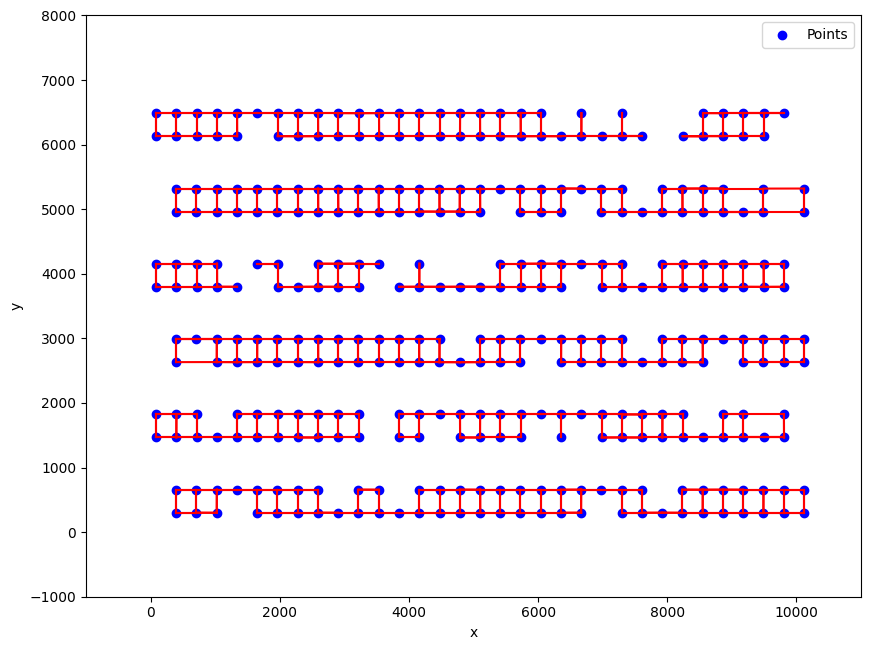

In [5]:
v_sbcd, e_sbcd = construct_grid_graph(circles_sbcd)
plot_edges(v_sbcd, e_sbcd)

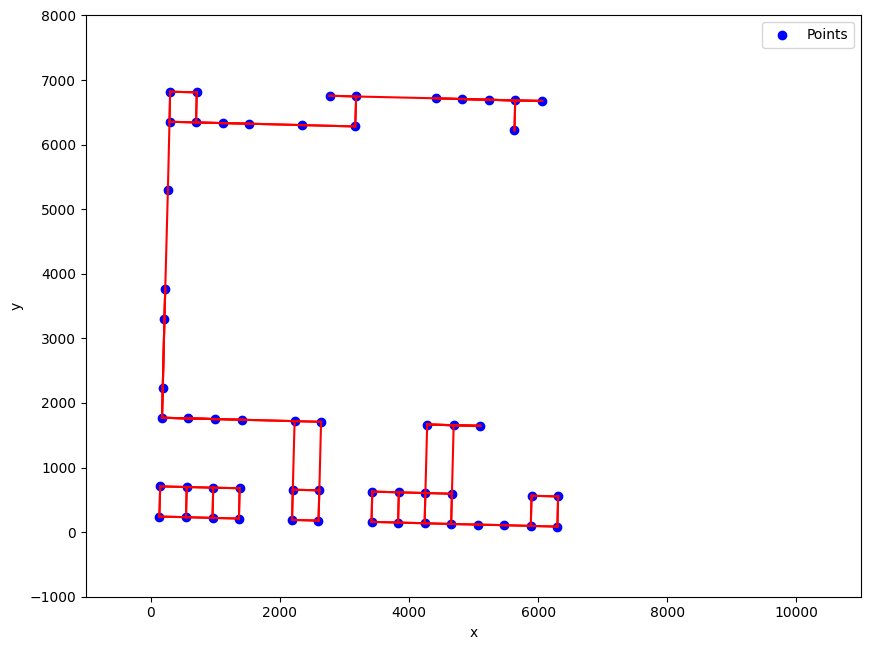

In [6]:
v_hist, e_hist = construct_grid_graph(circles_hist)
plot_edges(v_hist, e_hist)

## Step 3. Find Scale and Rotation

We are going to identify scale factor and rotation with the grid graphs.

### identify scale factor
When we examine the lengths of the edges in grid graph, there should be two prominent peaks: horizontal edges and vertical edges. We are going to find scale factor by comparing the shorter peaks from the two graphs.

In [7]:
def find_grid_lengths(edges, top_n=2):
    '''histogram based method'''
    lengths = [e[3] for e in edges]
    # Create a histogram
    hist, bin_edges = np.histogram(lengths, bins=1000)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Find peaks
    peaks, _ = find_peaks(hist)
    
    # Extract peak lengths
    peak_lengths = bin_centers[peaks]
        
    # Sort peaks by their frequency (height in the histogram)
    sorted_peak_indices = np.argsort(hist[peaks])[::-1]  # Sort in descending order
    
    # Get the x-values (edge lengths) of the top peaks
    top_peak_lengths = bin_centers[peaks][sorted_peak_indices]
    
    # Optional: Selecting the top N peaks, e.g., top 2
    top_n = 2  # You can change this number as needed
    top_peak_lengths = top_peak_lengths[:top_n]

    return top_peak_lengths

In [8]:
xgrid_sbcd = min(find_grid_lengths(e_sbcd))
xgrid_hist = min(find_grid_lengths(e_hist))
scale_factor = xgrid_sbcd /  xgrid_hist
scale_factor

0.7666887727748074

### Rotation
We are going to identify the proper rotation angle by minimizizng the error to the cardinal directions based on the assumption that sbcds are aligned to the cardinal direction.

In [9]:
def roundTo90(theta):
    """Round an angle to the nearest multiple of 90 degrees."""
    return round(theta / 90) * 90

def error_function_angle(alpha, angles):
    """Compute the sum of squared errors from the nearest cardinal direction for each angle."""
    total_error = 0
    for theta in angles:
        new_theta = (theta + alpha) % 360
        error = (roundTo90(new_theta) - new_theta) ** 2
        total_error += error
    return total_error

def find_optimal_rotation(angles):
    """Find the optimal rotation angle for a list of angles."""
    result = minimize_scalar(error_function_angle, args=(angles,))
    return result.x

In [10]:
rotation = find_optimal_rotation(calculate_bearing_angles(e_hist))
rotation

1.4580222221030468

## Step 4. Find Candidate Translations
Since we found rotation and scale, we need to find translation. We have limited possibility of translation since it can be limted to (V in histology graph) X (V in sbcd graph). Moreover, the possible translations are limited to the translation that bbox of histology falls inside to the bbox of sbcd.

In [11]:
def transform_points_matrix(source_point, target_point, rotation_angle, scale_factor):
    """
    construct a 3x3 transformation matrix.

    Parameters:
    source_point (tuple): The source 2D point to be moved to the origin.
    target_point (tuple): The target 2D point where the origin will be moved after transformations.
    rotation_angle (float): The rotation angle in degrees.
    scale_factor (float): The scale factor for scaling the points.

    Returns:
    transformation matrix 
    """

    # Translation matrix to move source point to the origin
    translation_to_origin = np.array([
        [1, 0, -source_point[0]],
        [0, 1, -source_point[1]],
        [0, 0, 1]
    ])

    # Rotation matrix
    angle_rad = np.radians(rotation_angle)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad), 0],
        [np.sin(angle_rad), np.cos(angle_rad), 0],
        [0, 0, 1]
    ])

    # Scaling matrix
    scaling_matrix = np.array([
        [scale_factor, 0, 0],
        [0, scale_factor, 0],
        [0, 0, 1]
    ])

    # Translation matrix to move origin to the target point
    translation_to_target = np.array([
        [1, 0, target_point[0]],
        [0, 1, target_point[1]],
        [0, 0, 1]
    ])

    # Combine all transformations into a single transformation matrix
    transformation_matrix = np.dot(np.dot(np.dot(translation_to_target, scaling_matrix), rotation_matrix), translation_to_origin)

    return transformation_matrix

def apply_transform_points(points, transformation_matrix):
    points_array = np.hstack([points, np.ones((len(points), 1))]) 
    points_transformed = np.dot(transformation_matrix, points_array.T).T
    points_transformed = points_transformed[:, :2]
    return points_transformed

def bbox(points, padding=0):
    x_coords, y_coords = zip(*points)
    min_x, min_y, max_x, max_y = min(x_coords), min(y_coords), max(x_coords), max(y_coords)
    return min_x - padding, min_y - padding, max_x + padding, max_y + padding

def is_contained(box1, box2):
    # Check if box1 is contained within box2
    return box1[0] >= box2[0] and box1[1] >= box2[1] and box1[2] <= box2[2] and box1[3] <= box2[3]

def find_overlapping_transform(A, B, rotation, scale_factor):
    '''identify transform that transformed B is within A'''
    # Calculate the bounding box for A just once
    bbox_A = bbox(A, 100)

    overlapping_transforms = []
    for point_B in B:
        for point_A in A:
            tm = transform_points_matrix(point_B, point_A, rotation, scale_factor)
            tf_B = apply_transform_points(B, tm)
            bbox_B = bbox(tf_B)
    
            # Check if the bounding box of B is contained within the bounding box of A
            if is_contained(bbox_B, bbox_A):
                overlapping_transforms.append(tm)

    return overlapping_transforms

Number of candidates: 2637


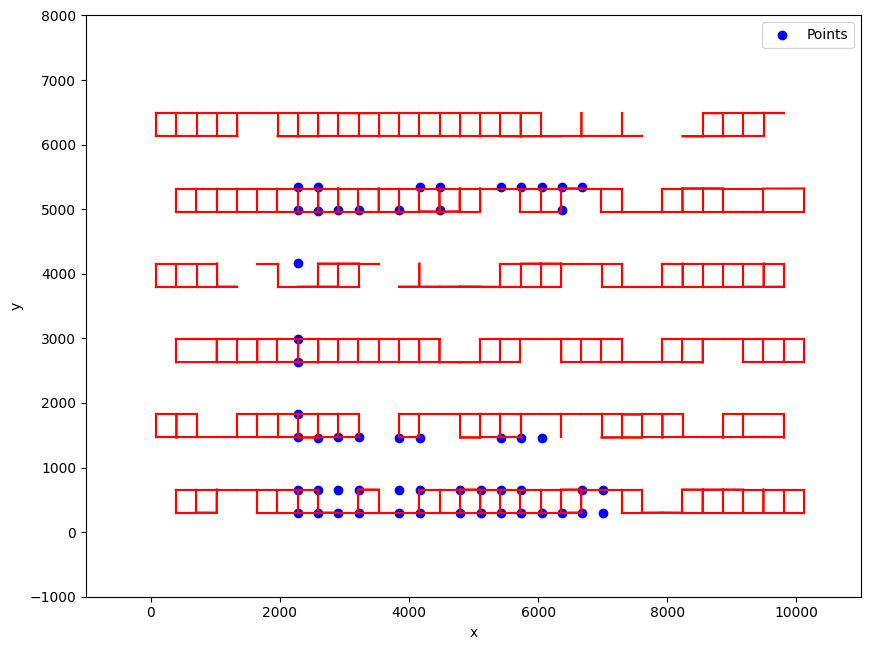

In [12]:
tms = find_overlapping_transform(v_sbcd, v_hist, rotation, scale_factor)
print("Number of candidates:", len(tms))
# example
v_tf = apply_transform_points(v_hist, tms[2000])
plot_edges(v_tf, e_sbcd)

## Step 5. Find the Best Transform
For eacch transform, we apply the transform to the histology image and compare the transformed image's red channel (mostly tissue)  with sbcd's red channel (the matched barcodes).

In [13]:
def stretch_contrast(image_layer, bottom_percentile=10, top_percentile=90):
    """Stretches the contrast of a single-channel image layer to the specified percentiles.

    Args:
        image_layer: The image layer as a NumPy array.
        bottom_percentile: The lower percentile to stretch to (default: 10).
        top_percentile: The upper percentile to stretch to (default: 90).

    Returns:
        The stretched image layer as a NumPy array with values between 0 and 255.
    """

    p_bottom = np.percentile(image_layer, bottom_percentile)
    p_top = np.percentile(image_layer, top_percentile)

    stretched_layer = np.clip((image_layer - p_bottom) / (p_top - p_bottom), 0, 1)
    stretched_layer = (stretched_layer * 255).astype(np.uint8)

    return stretched_layer

def find_best_transform(A, B, transforms, blur=7):
    """
    Finds the translation vector that minimizes the difference between A and the translated B.

    Args:
        A: The first image array.
        B: The second image array.
        transform: A list of transform matrices

    Returns:
        The transform matrix that minimizes the difference, 
    """
    A = stretch_contrast(cv2.medianBlur(A, blur))
    B = stretch_contrast(cv2.medianBlur(B, blur))
    min_error = np.inf
    best_tf = None

    for idx, tf in enumerate(transforms):
        if idx % 100 == 0: print(idx) 
            
        B_tf = cv2.warpAffine(B, tf[:2, :], (A.shape[1], A.shape[0]))
        error = np.sum(np.abs(A - B_tf))
        
        if error < min_error:
            min_error = error
            best_tf = tf

    return best_tf

In [14]:
sbcdf = "data/sbcd.png"
histf = "data/hist_90.tif"
sbcd_red = cv2.imread(sbcdf, cv2.IMREAD_UNCHANGED)[:,:,2]
hist_red = 255 - cv2.imread(histf, cv2.IMREAD_UNCHANGED)[:,:,2]  # inverse color

In [15]:
best_tf = find_best_transform(sbcd_red, hist_red, tms)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


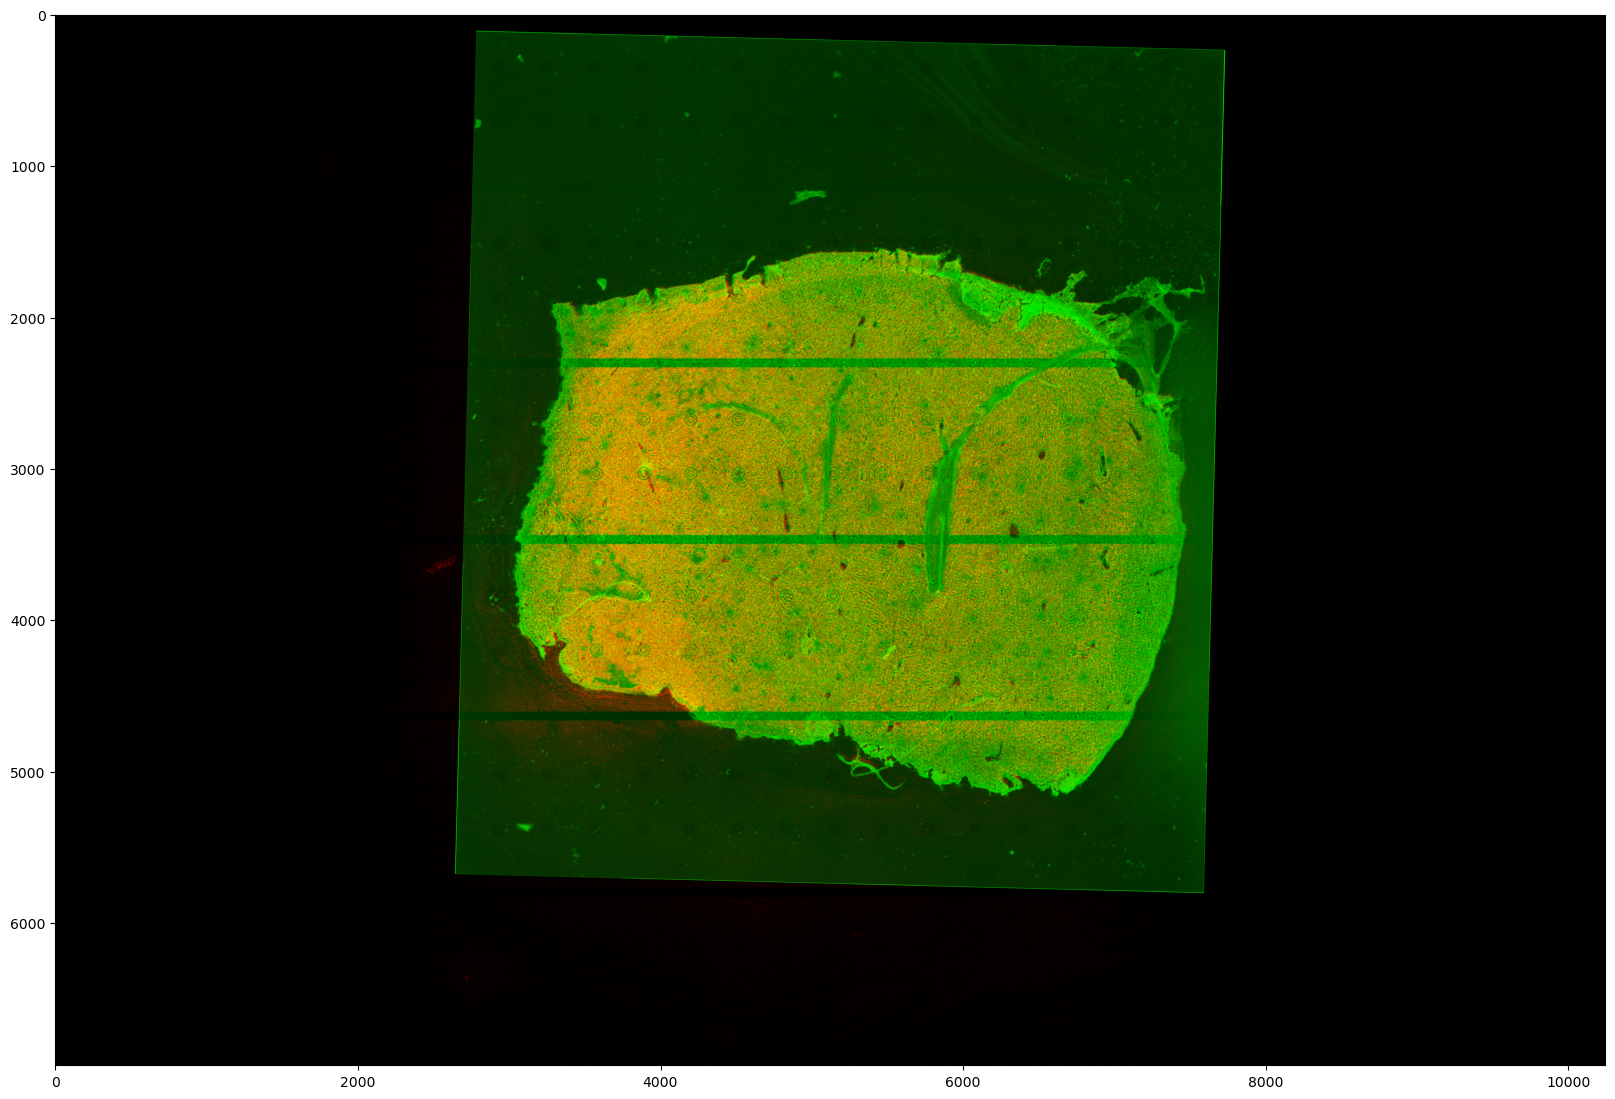

In [21]:
hist_match = cv2.warpAffine(hist_red, best_tf[:2, :], (sbcd_red.shape[1], sbcd_red.shape[0]))
zeros = np.zeros(sbcd_red.shape[:2], dtype="uint8")
merged = cv2.merge([sbcd_red, hist_match , zeros])  
plt.figure(figsize = (20,15))
plt.imshow(merged)